## gpt-3.5-turbo-instruct ELO Calibration

### Introduction

This notebook calibrates `gpt-3.5-turbo-instruct`'s chess ELO by pitting it against Stockfish configured at different levels.

### Methodology

100 games are played bertween `gpt-3.5-turbo-instruct` and Stockfish, with alternating turns as white. The calibration process starts with Stockfish configured at 1500 ELO, and continuously adjusts Stockfish's level according to the previous game's outcome. The process starts with a large adjustment [k-factor](https://en.wikipedia.org/wiki/Elo_rating_system#The_K-factor_used_by_the_USCF) of 128, which decays linearly to 8 over the course of the 100 games, as the estimated ELO converges towards `gpt-3.5-turbo-instruct`'s true playing ability.

`gpt-3.5-turbo-instruct` is prompted to complete a PGN notated game with a next move. Here's an example prompt (GPT's turn as White):

```text
[Event "World Championship"]
[Site "Moscow"]
[Date "2025.01.01"]
[Round "1"]
[White "Kasparov, Garry"]
[Black "Carlsen, Magnus"]
[Result "1-0"]
[WhiteElo "2800"]
[BlackElo "2800"]

1. e4 e5
2. Nf3 Nc6 
3.
```

`gpt-3.5-turbo-instruct` is _extremely_ sensitive to formatting, including minor alterations in whitespace. GPT is prompted to include a leading whitespace in its completion (e.g., `" e4"`) — omitting this degrades performance considerably.

The prompt also primes GPT to believe it's playing an elite-level game between two Super Grandmasters, and the Result header is dynamically updated to indicate a win for GPT, whether it plays white or black. Both of these prompt implementation details encourage GPT to play at its best (and not, for example, mimic a 1500 ELO casual player).


### Results

`gpt-3.5-turbo-instruct`'s ELO is estimated to be 1940. This is similar (perhaps slightly higher) than results reported elsewhere.

Of the 100 games, two (#80 and #84) were registered as losses for GPT due to illegal move selection.

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import sys

from pathlib import Path
import matplotlib.pyplot as plt

from llm_chess.players.llm.openai_instruct import GPT3p5TurboInstructPlayer
from llm_chess.utils.calibrate import calibrate_elo

logging.basicConfig(
    level=logging.WARNING,
    format="%(message)s",
    force=True
)

for module in [
    'llm_chess.players.llm.openai_instruct',
    'llm_chess.utils.calibrate',
]:
    logger = logging.getLogger(module)
    logger.setLevel(logging.INFO)
    logger.propagate = False

    handler = logging.StreamHandler(sys.stdout)
    handler.setFormatter(logging.Formatter("%(message)s"))
    logger.handlers = [handler]


In [2]:
INITIAL_LLM_ELO_ESTIMATE = 1500
NUM_GAMES = 100
PLAYER = GPT3p5TurboInstructPlayer()
START_K_FACTOR = 128
END_K_FACTOR = 8

PROJECT_ROOT = Path().cwd().parents[0]
LOG_DIR = PROJECT_ROOT / "game_logs" / "gpt_3p5_turbo_instruct_calibration"
LOG_DIR.mkdir(parents=True, exist_ok=True)

game_scores_and_elos = calibrate_elo(
    PLAYER,
    initial_llm_elo_estimate=INITIAL_LLM_ELO_ESTIMATE,
    num_games=NUM_GAMES,
    start_k_factor=START_K_FACTOR,
    end_k_factor=END_K_FACTOR,
    write_dir=LOG_DIR,
)

--- Starting Player ELO Calibration ---
Initial Player ELO    : 1500
Initial Stockfish ELO : 1500
Number of Games       : 100
K-Factor              : 128 to 8
-----------------------------------

Game 1/100:
  Setting Stockfish ELO to: 1500
  Player played white. Game result: 1-0
  Player ELO updated from 1500 to 1564 (K-Factor: 128)

Game 2/100:
  Setting Stockfish ELO to: 1564
  Player played black. Game result: 0-1
  Player ELO updated from 1564 to 1627 (K-Factor: 126)

Game 3/100:
  Setting Stockfish ELO to: 1627
  Player played white. Game result: 1-0
  Player ELO updated from 1627 to 1689 (K-Factor: 125)

Game 4/100:
  Setting Stockfish ELO to: 1689
  Player played black. Game result: 1-0
  Player ELO updated from 1689 to 1627 (K-Factor: 124)

Game 5/100:
  Setting Stockfish ELO to: 1627
  Player played white. Game result: 1-0
  Player ELO updated from 1627 to 1688 (K-Factor: 123)

Game 6/100:
  Setting Stockfish ELO to: 1688
  Player played black. Game result: 0-1
  Player ELO u

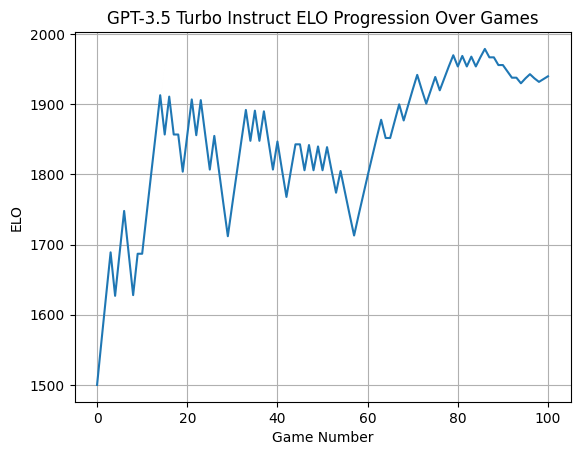

In [3]:
elos = [elo for _, elo in [(None, INITIAL_LLM_ELO_ESTIMATE)] + game_scores_and_elos]
plt.plot(elos)
plt.xlabel("Game Number")
plt.ylabel("ELO")
plt.title(f"{PLAYER.name} ELO Progression Over Games")
plt.grid(True)
plt.show()